In [ ]:
!chemprop_train \
  --data_path ../4.1_data/4.1.2_processed/02_EGFR_inhinitor_processed_classification.csv \
  --dataset_type classification \
  --target_columns bin_activity \
  --smiles_columns smiles \
  --save_dir ../4.3_chemprop_results \
  --split_type scaffold_balanced \
  --num_folds 5 \
  --ensemble_size 2 \
  --metric auc \
  --extra_metrics prc-auc accuracy \
  --batch_size 64 \
  --dropout 0.2 \
  --epochs 40 \
  --save_preds \
  --num_workers 0 \
  --gpu 0 \


Reading chemprop_egfr_classification_withpreds_2/fold_0/test_preds.csv
  fold 0: NaN in y_true = 51
  fold 0: AUC = 0.8437
Reading chemprop_egfr_classification_withpreds_2/fold_1/test_preds.csv
  fold 1: NaN in y_true = 32
  fold 1: AUC = 0.8773
Reading chemprop_egfr_classification_withpreds_2/fold_2/test_preds.csv
  fold 2: NaN in y_true = 90
  fold 2: AUC = 0.8671
Reading chemprop_egfr_classification_withpreds_2/fold_3/test_preds.csv
  fold 3: NaN in y_true = 67
  fold 3: AUC = 0.8976
Reading chemprop_egfr_classification_withpreds_2/fold_4/test_preds.csv
  fold 4: NaN in y_true = 37
  fold 4: AUC = 0.8936

Overall (all folds combined) AUC = 0.8757


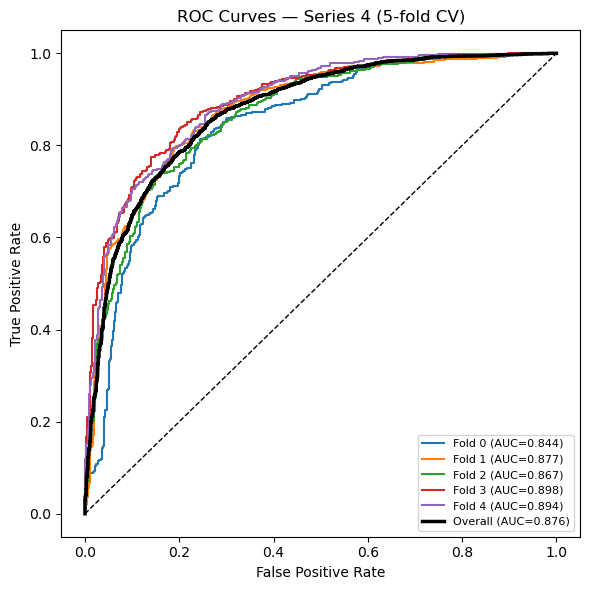

In [4]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

base_dir = "chemprop_egfr_classification_withpreds_2"
data_path = "EGFR_inhibitor_processed_classification.csv"

# 讀原始資料 label
data = pd.read_csv(data_path)
data_small = data[["smiles", "bin_activity"]].copy()
data_small = data_small.rename(columns={"bin_activity": "y_true"})

# 存所有 fold 的資料（用來合併算 overall ROC）
all_folds_df = []

plt.figure(figsize=(6, 6))

for fold in range(5):
    preds_path = os.path.join(base_dir, f"fold_{fold}", "test_preds.csv")
    print(f"Reading {preds_path}")
    
    preds = pd.read_csv(preds_path)
    
    # 清理 smiles
    preds["smiles"] = preds["smiles"].str.strip("[]'")
    
    preds = preds.rename(columns={"bin_activity": "pred"})
    
    df = preds.merge(data_small, on="smiles", how="left")
    
    nan_count = df["y_true"].isna().sum()
    print(f"  fold {fold}: NaN in y_true = {nan_count}")
    
    df_clean = df.dropna(subset=["y_true"]).copy()
    df_clean["y_true"] = df_clean["y_true"].astype(int)
    
    # 存起來做 overall ROC 使用
    df_clean["fold"] = fold
    all_folds_df.append(df_clean)
    
    y_true = df_clean["y_true"]
    y_score = df_clean["pred"]   # ← 修正這裡
    
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    
    print(f"  fold {fold}: AUC = {roc_auc:.4f}")
    
    plt.plot(fpr, tpr, lw=1.5, label=f"Fold {fold} (AUC={roc_auc:.3f})")

# 合併後 overall ROC
all_df = pd.concat(all_folds_df, ignore_index=True)
y_true_all = all_df["y_true"]
y_score_all = all_df["pred"]

fpr_all, tpr_all, _ = roc_curve(y_true_all, y_score_all)
roc_auc_all = auc(fpr_all, tpr_all)
print(f"\nOverall (all folds combined) AUC = {roc_auc_all:.4f}")

# overall 粗線
plt.plot(fpr_all, tpr_all, lw=2.5, color="black", label=f"Overall (AUC={roc_auc_all:.3f})")

# 圖設定
plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves — Series 4 (5-fold CV)")
plt.legend(loc="lower right", fontsize=8)
plt.tight_layout()
plt.show()

# 存圖（給 poster）
# plt.savefig("series4_5fold_roc.png", dpi=300, bbox_inches="tight")


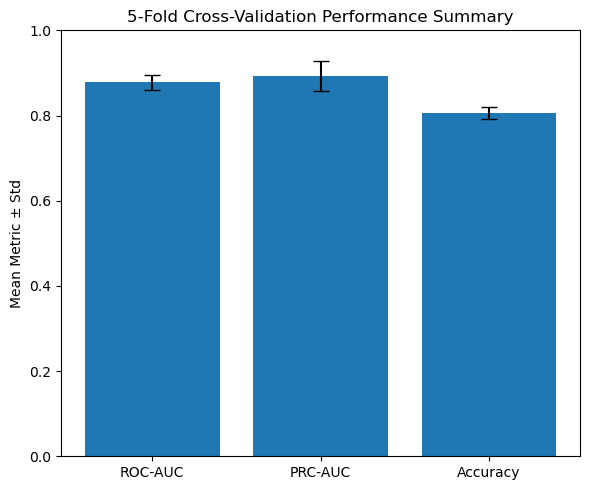

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

scores = pd.read_csv("chemprop_egfr_classification_withpreds_2/test_scores.csv")

# 取出資料
mean_auc = scores["Mean auc"].values[0]
std_auc = scores["Standard deviation auc"].values[0]

mean_prc = scores["Mean prc-auc"].values[0]
std_prc = scores["Standard deviation prc-auc"].values[0]

mean_acc = scores["Mean accuracy"].values[0]
std_acc = scores["Standard deviation accuracy"].values[0]

metrics = ["ROC-AUC", "PRC-AUC", "Accuracy"]
means = [mean_auc, mean_prc, mean_acc]
errors = [std_auc, std_prc, std_acc]

plt.figure(figsize=(6,5))
plt.bar(metrics, means, yerr=errors, capsize=6)
plt.ylabel("Mean Metric ± Std")
plt.title("5-Fold Cross-Validation Performance Summary")
plt.ylim(0,1)
plt.tight_layout()
plt.show()

# 可存圖:
# plt.savefig("cv_performance_summary.png", dpi=300, bbox_inches="tight")

PRC-AUC = 0.9320


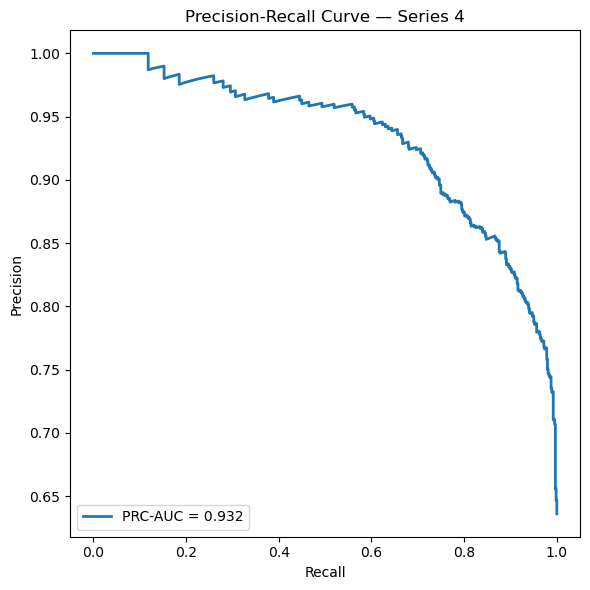


Confusion matrix (threshold=0.5):
[[272  96]
 [ 84 559]]


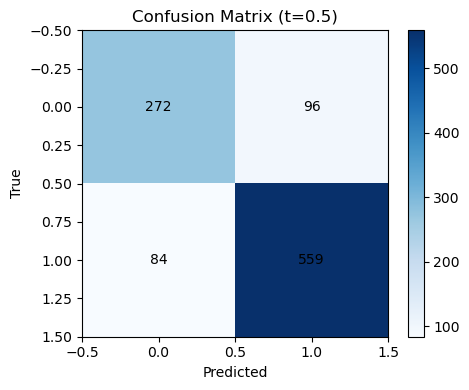


Decision table (0.3–0.7):
   threshold   TP   FP   FN   TN  precision  recall
0        0.3  595  140   48  228      0.810   0.925
1        0.4  581  122   62  246      0.826   0.904
2        0.5  559   96   84  272      0.853   0.869
3        0.6  531   84  112  284      0.863   0.826
4        0.7  510   69  133  299      0.881   0.793


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    confusion_matrix
)

# ===== 我們直接用上一段已經合併好的 df_clean =====
df_plot = df_clean.copy()

y_true = df_plot["y_true"].astype(int)
y_score = df_plot["pred"]

# ========= 1️⃣ PRC curve =========
precision, recall, pr_thresholds = precision_recall_curve(y_true, y_score)
prc_auc = average_precision_score(y_true, y_score)
print(f"PRC-AUC = {prc_auc:.4f}")

plt.figure(figsize=(6,6))
plt.plot(recall, precision, linewidth=2, label=f"PRC-AUC = {prc_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve — Series 4")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()
# plt.savefig("series4_overall_prc.png", dpi=300)

# ========= 2️⃣ Confusion Matrix (threshold = 0.5) =========
thresh = 0.5
y_pred = (y_score >= thresh).astype(int)
cm = confusion_matrix(y_true, y_pred)

print("\nConfusion matrix (threshold=0.5):")
print(cm)

plt.figure(figsize=(5,4))
plt.imshow(cm, cmap="Blues")
plt.title(f"Confusion Matrix (t={thresh})")
plt.colorbar()
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()
# plt.savefig("series4_confusion_matrix.png", dpi=300)

# ========= 3️⃣ Decision table =========
thresholds = np.arange(0.3, 0.71, 0.1)
results = []

for t in thresholds:
    yp = (y_score >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, yp).ravel()
    precision = tp / (tp + fp) if (tp+fp) > 0 else 0
    recall = tp / (tp + fn) if (tp+fn) > 0 else 0
    results.append([t, tp, fp, fn, tn, precision, recall])

dec_table = pd.DataFrame(results, columns=["threshold", "TP", "FP", "FN", "TN", "precision", "recall"])
print("\nDecision table (0.3–0.7):")
print(dec_table.round(3))

# dec_table.to_csv("decision_table_thresholds.csv", index=False)


NameError: name 'hi' is not defined